<a href="https://colab.research.google.com/github/vjanapaty/Estuarine_Research/blob/main/SF_estuary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('drive')
os.chdir('drive/MyDrive/2022 SNPS')

Mounted at drive


In [ ]:
#Shree
#shree
!pip install geopandas
!pip install descartes 
!pip install geemap
!pip install folium
!pip install seaborn
!pip install wxee
!pip install eemont
!pip install geetools
!pip install datetime

In [ ]:
#Import earth engine
import ee
 
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=AHm4pWXWaJ0197TN2uqG8QzAvDmRI-yjxFewHOUke-k&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjynBssNpv8oNrwG9xb1ugtjJusKPiRvN2M-MOH19hWRVOJvaJ8AKQ

Successfully saved authorization token.


In [ ]:
import ee
import folium 
import numpy as np # yes, numpy!
import pandas as pd # yes, pandas!
import seaborn as sns
import matplotlib.pyplot as plt 
from pandas.plotting import register_matplotlib_converters
import pprint as pp
from google.colab import data_table
from vega_datasets import data
import json, geemap
import geopandas as gpd
from geetools import tools
from geetools import cloud_mask
from PIL import Image
import requests, zipfile, io
from IPython.display import Image
from datetime import datetime

Loading Shapefile...


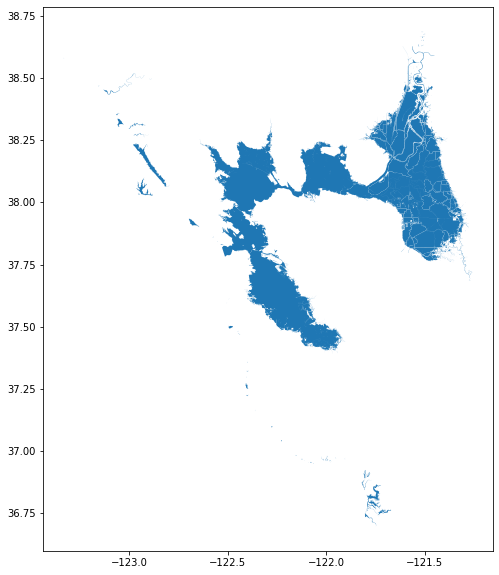

In [ ]:
print("Loading Shapefile...")
shapefile1 = gpd.read_file("SHAPEFILES/SFBAY_1/PMEP_EstuaryExtent_SFtoElkhorn-polygon.shp")
shapefile1.plot(figsize=(20, 10))

Loading Shapefile...


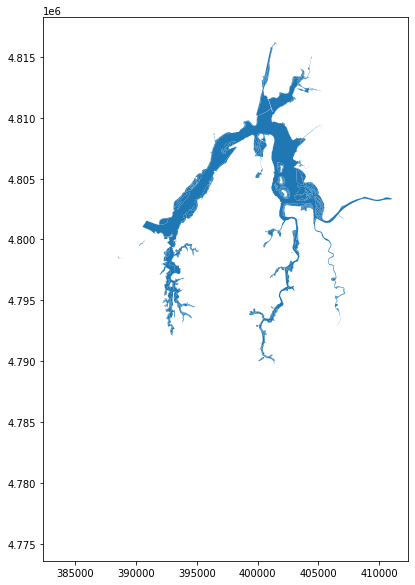

In [ ]:
print("Loading Shapefile...")
shapefile1 = gpd.read_file("New_shapefiles/SOUTH/NWI_tidal_SouthSlough.shp")
shapefile1.plot(figsize=(20, 10))

In [ ]:
shp = gpd.read_file("New_shapefiles/ELK/NWI_Tidal_Elkhorn.shp")
shp
shp["Name"].str.find('San Francisco Bay')

In [ ]:

temp = shp[shp["Name"].str.contains('San Francisco Bay')]

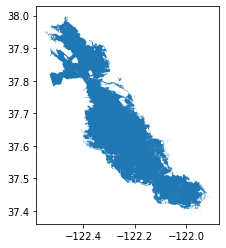

In [ ]:
temp.plot()


In [ ]:
from shapely.geometry import Point, LineString, Polygon
def swap2(x):
    coords = list(x.coords)
    coords = [Point(t[0], t[1]) if (((t[1]>37.4) or (t[1]<38.5)) and ((t[0]>-122.7) or (t[0]<-121.75))) else Point(0,0)  for t in coords ] 
    return Polygon(coords)

shp = gpd.read_file("SHAPEFILES/SFBAY_1/PMEP_EstuaryExtent_SFtoElkhorn-polygon.shp")
tempete = shp.geometry.map(swap2)

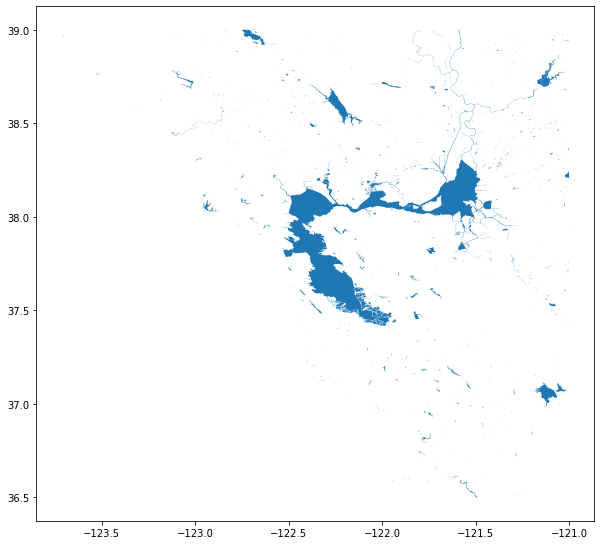

In [ ]:
tempete.plot(figsize=(10, 10))

In [ ]:
tempete.describe()
tempete.to_file("SHAPEFILES/SFBAY_T/sfbay.shp")

In [ ]:
# Best code to GET ALL LANDSAT 7 IMAGES
#Calculate NDVI for each image of image collection.
# Removed gt(0) because we eed ndvi < 0
# No poi_mean done here - we do not want to mean the images

visparams = {
    'palette':['8B0000','FF0000', 'FF4500', 'FFFF00', '00FF00','008000', '006400'],
    'min':-1,'max':1
    }
def createB1(image):
    image.visualize(**visparams)
    b1 = image.select(['B7']).rename('B7')#.gt(0)
    return image.addBands(b1)

#clip out elkhorn
def clip_image(image):  #Need to add mask here
  return image.clip(elkhorn)

#def poi_mean(img):
#  mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=elkhorn, scale=30).get('NDVI')
#  return img.set('date', img.date().format()).set('NDVI',mean)#.set('system:time_start', ee.Date.fromYMD(y, m, 5)).rename(date)

#For landsat 7 "LANDSAT/LE07/C01/T1_SR" 
#startDate = '2013-03-18' #FIRST DATE THAT LANDSAT 8 IS AVAILABLE
#endDate = '2022-02-25'
#In Landsat 4-7, NDVI = (Band 4 – Band 3) / (Band 4 + Band 3).
#For landsat 8 "LANDSAT/LC08/C01/T1_SR"
#startDate = '2013-03-18' #FIRST DATE THAT LANDSAT 7 IS AVAILABLE
#endDate = '2022-02-25'
#In Landsat 8, NDVI = (Band 5 – Band 4) / (Band 5 + Band 4).


elkmap = geemap.Map(center=[36.8058,-121.790],zoom=13)
elkhorn = geemap.shp_to_ee("New_shapefiles/SOUTH/NWI_tidal_SouthSlough.shp")

#defining image
startDate = '1999-05-28' #FIRST DATE THAT LANDSAT 7 IS AVAILABLE
endDate = '2022-02-25'

landsat = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
# filter date
landsat = landsat.filterDate(startDate, endDate)
#Add NDVI
#landsat_B1=landsat.map(createB1)

#applying cloud masking
landsat_masked=landsat.map( cloud_mask.landsatSR(['cloud']) )
#apply clipping
landsat_clipped = landsat_masked.map(clip_image)

#selecting bands
landsat_masked=landsat_masked.select(['B1','B2','B3','B4','B5','B6','B7'])
landsat = landsat_clipped.select(['B1','B2','B3','B4','B5','B6','B7'])



elkCloudlessB1 = landsat.map(clip_image)
elkmap.addLayer(landsat.select(['B1','B2','B3','B4','B5','B6','B7'])) #, visparams)

elkmap.addLayer(elkhorn, {}, 'Elkhorn')

elkmap

Map(center=[36.8058, -121.79], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

In [ ]:
# Best code to GET ALL LANDSAT 7 IMAGES
#Calculate NDVI for each image of image collection.
# Removed gt(0) because we eed ndvi < 0
# No poi_mean done here - we do not want to mean the images

visparams = {
    'palette':['8B0000','FF0000', 'FF4500', 'FFFF00', '00FF00','008000', '006400'],
    'min':-1,'max':1
    }
def createB1(image):
    image.visualize(**visparams)
    b1 = image.select(['B1']).rename('B1')#.gt(0)
    return image.addBands(b1)

#clip out elkhorn
def clip_image(image):  #Need to add mask here
  return image.clip(elkhorn)

#def poi_mean(img):
#  mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=elkhorn, scale=30).get('NDVI')
#  return img.set('date', img.date().format()).set('NDVI',mean)#.set('system:time_start', ee.Date.fromYMD(y, m, 5)).rename(date)

#For landsat 7 "LANDSAT/LE07/C01/T1_SR" 
#startDate = '2013-03-18' #FIRST DATE THAT LANDSAT 8 IS AVAILABLE
#endDate = '2022-02-25'
#In Landsat 4-7, NDVI = (Band 4 – Band 3) / (Band 4 + Band 3).
#For landsat 8 "LANDSAT/LC08/C01/T1_SR"
#startDate = '2013-03-18' #FIRST DATE THAT LANDSAT 7 IS AVAILABLE
#endDate = '2022-02-25'
#In Landsat 8, NDVI = (Band 5 – Band 4) / (Band 5 + Band 4).


elkmap = geemap.Map(center=[36.8058,-121.790],zoom=13)
elkhorn = geemap.shp_to_ee("New_shapefiles/SOUTH/NWI_tidal_SouthSlough.shp")

#defining image
startDate = '1999-05-28' #FIRST DATE THAT LANDSAT 7 IS AVAILABLE
endDate = '2022-02-25'

landsat = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
# filter date
landsat = landsat.filterDate(startDate, endDate)
#Add NDVI
landsat_B1=landsat.map(createB1)

#applying cloud masking
landsat_masked=landsat_B1.map( cloud_mask.landsatSR(['cloud']) )
#apply clipping
landsat_clipped = landsat_masked.map(clip_image)

#selecting bands
landsat_masked=landsat_masked.select(["B1"])
landsat = landsat_clipped.select(["B1"])



elkCloudlessB1 = landsat.map(clip_image)
elkmap.addLayer(elkCloudlessB1.select('B1'), visparams)

elkmap.addLayer(elkhorn, {}, 'Elkhorn')

elkmap

In [ ]:
# Best code to GET ALL LANDSAT 7 IMAGES
#Calculate NDVI for each image of image collection.
# Removed gt(0) because we eed ndvi < 0
# No poi_mean done here - we do not want to mean the images

visparams = {
    'palette':['8B0000','FF0000', 'FF4500', 'FFFF00', '00FF00','008000', '006400'],
    'min':-1,'max':1
    }
def createB1(image):
    image.visualize(**visparams)
    b1 = image.select(['B1']).rename('B1')#.gt(0)
    return image.addBands(b1)

#clip out elkhorn
def clip_image(image):  #Need to add mask here
  return image.clip(elkhorn)

#def poi_mean(img):
#  mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=elkhorn, scale=30).get('NDVI')
#  return img.set('date', img.date().format()).set('NDVI',mean)#.set('system:time_start', ee.Date.fromYMD(y, m, 5)).rename(date)

#For landsat 7 "LANDSAT/LE07/C01/T1_SR" 
#startDate = '2013-03-18' #FIRST DATE THAT LANDSAT 8 IS AVAILABLE
#endDate = '2022-02-25'
#In Landsat 4-7, NDVI = (Band 4 – Band 3) / (Band 4 + Band 3).
#For landsat 8 "LANDSAT/LC08/C01/T1_SR"
#startDate = '2013-03-18' #FIRST DATE THAT LANDSAT 7 IS AVAILABLE
#endDate = '2022-02-25'
#In Landsat 8, NDVI = (Band 5 – Band 4) / (Band 5 + Band 4).


elkmap = geemap.Map(center=[36.8058,-121.790],zoom=13)
elkhorn = geemap.shp_to_ee("New_shapefiles/SOUTH/NWI_tidal_SouthSlough.shp")

#defining image
startDate = '1999-05-28' #FIRST DATE THAT LANDSAT 7 IS AVAILABLE
endDate = '2022-02-25'

landsat = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
# filter date
landsat = landsat.filterDate(startDate, endDate)
#Add NDVI
#landsat_B1=landsat.map(createB1)

#applying cloud masking
landsat_masked=landsat.map( cloud_mask.landsatSR(['cloud']) )
#apply clipping
landsat_clipped = landsat_masked.map(clip_image)

#selecting bands
landsat_masked=landsat_masked #.select(["B1"])
landsat = landsat_clipped #.select(["B1"])



#elkCloudlessB1 = landsat.map(clip_image)
#elkmap.addLayer(elkCloudlessB1.select('B1'), visparams)
elkmap.addLayer(landsat)
elkmap.addLayer(elkhorn, {}, 'Elkhorn')

elkmap

In [ ]:
landsat.first().bandNames().getInfo()

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

In [ ]:
#This one is most current
# We cannot do poi_image for every image, instead mean image must be for for an image collection as a whole

months = ee.List.sequence(1, 12)
#years = ee.List.sequence(1999, 2022)
# This routine calculates climatology for all the years 2013 - 2022
# It will generate 12 images that represent the climatology across 2013 - 2022

def filter_by_month(m):
  landsat_per_month = landsat.filter(ee.Filter.calendarRange(m, m, 'month'))
  #filter_by_month(m)
  mean_image = ee.Image(landsat_per_month.reduce(reducer=ee.Reducer.mean()))
  #print(mean_image.getInfo())
  return mean_image.set('month', m)
#  .set('system:time_start', ee.Date.fromYMD(y,m, 5))

# To test for single image
#image = filter_by_month(7)
#print(image.getInfo())


landsat_climatology_byMonth = ee.ImageCollection.fromImages(months.map(filter_by_month).flatten())
p = pp.PrettyPrinter(indent=4)

#print(landsat_climatology_byMonth.size().getInfo())
#p.pprint(landsat_climatology_byMonth.first().getInfo())


In [ ]:

#This one is most current
# We cannot do poi_image for every image, instead mean image must be for for an image collection as a whole
# This code gets monthly averages per year
# Note JAn - Apr 1999 had no landsat 7 data; certains months in 2003 also had landsat 7 failures
# This is handled in def by_year_anomaly(y) by returning the climatology itself is ndwi data isn't present

months = ee.List.sequence(1, 12)
years = ee.List.sequence(1999, 2021)

def filter_by_year(y):
  landsat_per_year = landsat.filter(ee.Filter.calendarRange(y, y, 'year'))
  def filter_by_month(m):
    landsat_per_month = landsat_per_year.filter(ee.Filter.calendarRange(m, m, 'month'))
    mean_image = ee.Image(landsat_per_month.reduce(reducer=ee.Reducer.mean()))
    #print(mean_image.getInfo())
    image = ee.Image(mean_image.set('month', m).set('year', y)
                    .set('system:time_start', ee.Date.fromYMD(y,m, 5)))
    image2 = ee.Image(landsat_climatology_byMonth.filter(ee.Filter.eq('month', m)).first().set('year', y)
                    .set('system:time_start', ee.Date.fromYMD(y,m, 5))) # This represents the monthly climatology
    image = ee.Algorithms.If(ee.Number(image.bandNames().size()).gt(0),
                          image,
                          image2) # send back the climatology image if image doesn't exist due to landsat 7 issues
    return image
  return months.map(filter_by_month)

# Debugging test for single year
#images = filter_by_year(1999)
#print(images.size().getInfo())
#print(images.getInfo())
# For all images
landsat_byYear_byMonth = ee.ImageCollection.fromImages(years.map(filter_by_year).flatten())

# Very Useful
#landsat_byYear_byMonth.first().bandNames().size().getInfo()

#print(str(landsat_byYear_byMonth.size().getInfo()) + " images generated")
p = pp.PrettyPrinter(indent=4)
#p.pprint(landsat_byYear_byMonth.first().getInfo())


#print(landsat_climatology_byMonth.first().getInfo())



In [ ]:
# Prerequisite : requires filter_by_year to be run
#months = ee.List.sequence(1, 12)
#years = ee.List.sequence(1999, 2021) Commented out because it should be same as filter_by_year
# If the ee.Algorithms.If isn't present the following error occurs -
# EEException: Image.subtract: If one image has no bands, the other must also have no bands. Got 0 and 1.

# image1 = image2 if landsat 7 didn't have the image
# This is taken care of in filter_by_year

def by_year_anomaly(y):
  landsat_per_year = landsat_byYear_byMonth.filter(ee.Filter.eq('year',y))
  def by_month_anomaly(m):
    image1 = ee.Image(landsat_per_year.filter(ee.Filter.eq('month', m)).first()) # This represents the monthly average for year y
    image2 = ee.Image(landsat_climatology_byMonth.filter(ee.Filter.eq('month', m)).first()) # This represents the monthly climatology
    diff = image1.subtract(image2)
    diff = ee.Image(diff)
    return diff.set('month', m).set('year', y)
  return months.map(by_month_anomaly)

anomaly_byYear_byMonth = ee.ImageCollection.fromImages(years.map(by_year_anomaly).flatten())

#print(str(anomaly_byYear_byMonth.size().getInfo())+ " images generated")
p = pp.PrettyPrinter(indent=4)
#p.pprint(anomaly_byYear_byMonth.first().getInfo())
#p.pprint(landsat_climatology_byMonth.first().getInfo())

In [ ]:
ls All_Bands_CSV_files/SFBAY

all_SFBAY_Merged.csv


In [ ]:

#Function get_image_mean calcultes the mean of an image and prepares the dictionary for export to csv file
#Shree
def get_image_mean(img):
  dict_1 = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=elkhorn, scale=30)
  month = img.get('month')
  year = img.get('year')
  dict_2 = ee.Dictionary({
    'month': month,
    'year': year
  })
  result = dict_1.combine(dict_2)
  return ee.Feature(None, result) 

def get_image_anomaly_mean(img):
  dict_1 = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=elkhorn, scale=30)
  month = img.get('month')
  year = img.get('year')
  dict_2 = ee.Dictionary({
    'month': month,
    'year': year
  })
  result = dict_1.combine(dict_2)
  return ee.Feature(None, result)

avg_anomaly = anomaly_byYear_byMonth.map(get_image_anomaly_mean)
p = pp.PrettyPrinter(indent=4)
print(avg_anomaly.size().getInfo())
p.pprint(avg_anomaly.first().getInfo())
task=ee.batch.Export.table.toDrive(collection=avg_anomaly,folder='All_Bands_CSV_files',description='all_bands_avg_anomaly_south',fileFormat='CSV')
task_id = task.start()
print(task_id)

avg_monthly = landsat_byYear_byMonth.map(get_image_mean)
p = pp.PrettyPrinter(indent=4)
print(avg_monthly.size().getInfo())
p.pprint(avg_monthly.first().getInfo())
task=ee.batch.Export.table.toDrive(collection=avg_monthly,folder='All_Bands_CSV_files',description='all_bands_avg_monthly_south',fileFormat='CSV')
task_id = task.start()
print(task_id)

#made change for column name untested

# To test for single file for debugging
#listOfImages = anomaly_byYear_byMonth.toList(anomaly_byYear_byMonth.size())
#img = ee.Image(listOfImages.get(4))
#print(img.getInfo())
#feat = get_image_mean(img)
#print(feat.getInfo())

#Finished running this

276
{   'geometry': None,
    'id': '0',
    'properties': {   'B1_mean': 0,
                      'B2_mean': 0,
                      'B3_mean': 0,
                      'B4_mean': 0,
                      'B5_mean': 0,
                      'B6_mean': 0,
                      'B7_mean': 0,
                      'month': 1,
                      'year': 1999},
    'type': 'Feature'}
None
276
{   'geometry': None,
    'id': '0',
    'properties': {   'B1_mean': 1291.6104885878603,
                      'B2_mean': 1229.7999593414036,
                      'B3_mean': 1170.3990178798126,
                      'B4_mean': 1303.1178797453333,
                      'B5_mean': 851.1283968871015,
                      'B6_mean': 2760.123796713479,
                      'B7_mean': 626.0052317449346,
                      'month': 1,
                      'year': 1999},
    'type': 'Feature'}
None


In [ ]:
df = pd.read_csv('All_Bands_CSV_files/TIJ/all_bands_avg_anomaly_Tij.csv')
df.rename(columns={'B1_mean': 'B1_anomaly', 'B2_mean': 'B2_anomaly', 'B3_mean': 'B3_anomaly'
, 'B4_mean': 'B4_anomaly', 'B5_mean': 'B5_anomaly', 'B6_VCID_1_mean': 'B6_VCID_1_anomaly', 'B6_VCID_2_mean': 'B6_VCID_2_anomaly'
, 'B7_mean': 'B7_anomaly', 'B8_mean': 'B8_anomaly', 'BQA_mean': 'BQA_anomaly'}, inplace=True)

df.drop('.geo', 1, inplace=True)
df.to_csv('All_Bands_CSV_files/TIJ/all_bands_avg_anomaly_Tij_1.csv')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
# Must only be run if new VI files were created
import time
def cleanup_file (filename):
  infile = 'All_Bands_CSV_files/TIJ/'+filename
  df_vi = pd.read_csv(open(infile,'r'), encoding='utf-8', engine='c')
  df_vi["month"] = df_vi["month"].astype(int).map("{:02}".format).astype(str)
  df_vi["year"] = df_vi["year"].astype(int).astype(str)
  cols=["year","month"]

  date = df_vi[cols].apply(lambda x: '-'.join(x.values), axis="columns")

  df_vi = df_vi.drop('year', 1) # where 1 is the axis number (0 for rows and 1 for columns.)
  df_vi = df_vi.drop('month', 1)
  #df_vi = df_vi.drop('.geo', 1)

  df_vi.insert(loc=0, column='Date', value=date)
  df_vi.reset_index(drop=True, inplace=True)
  df_vi = df_vi.drop('system:index',1)

  df_vi.head(5)
  outfile = 'All_Bands_CSV_files/TIJ/' +filename
  df_vi.to_csv(outfile)
  time.sleep(2)



filenames = ['all_bands_avg_anomaly_Tij_1.csv', 'all_bands_avg_monthly_Tij.csv']

for file in filenames:
  cleanup_file(file)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
right = pd.read_csv('From_Elkhorn_CSV/mean_all_NUT_merged.csv')
right.head(5)

df_join_no_duplicates = left.set_index('Date').join(right.set_index('Date'))

df_join_no_duplicates.to_csv('All_Bands_CSV_files/all_ELK_Merged.csv')

In [ ]:
from re import I
#Merges all the VI files with ELK files
def merge_file(file, left):
  filename = 'All_Bands_CSV_files/TIJ' + file
  print(filename)
  right = pd.read_csv(filename)
  right.head(5)
  result = pd.merge(left, right)
  if 'Unnamed: 0' in result.columns:
    left = result.drop('Unnamed: 0', 1)
  if '.geo'in result.columns:
    left = left.drop('.geo', 1)
  if 'Unnamed: 0.1' in result.columns:
    left = left.drop('Unnamed: 0.1', 1)
  return(left)


filenames = ['all_bands_avg_anomaly.csv', 'all_bands_avg_monthly.csv']
left = pd.read_csv('All_Bands_CSV_files/all_ELK_Merged.csv')
for file in filenames:
  left = merge_file(file, left)


left.head(5)


left.to_csv('All_Bands_CSV_files/all_Merged.csv')

In [ ]:
df = pd.read_csv('All_Bands_CSV_files/all_Merged.csv')
df.rename(columns={'Temp_mean': 'ELK_Temp_mean', 'Temp_anomaly': 'ELK_Temp_anomaly', 'SpCond_mean': 'ELK_SpCond_mean'
, 'SpCond_anomaly': 'ELK_SpCond_anomaly', 'Sal_mean': 'ELK_Sal_mean', 'Sal_anomaly': 'ELK_Sal_anomaly', 'DO_mgl_mean': 'ELK_DO_mgl_mean'
, 'DO_mgl_anomaly': 'ELK_DO_mgl_anomaly', 'pH_mean': 'ELK_pH_mean', 'pH_anomaly': 'ELK_pH_anomaly'
, 'Turb_mean': 'ELK_Turb_mean', 'Turb_anomaly': 'ELK_Turb_anomaly', 'PO4F_mean': 'ELK_PO4F_mean'
, 'PO4F_anomaly': 'ELK_PO4F_anomaly', 'NH4F_mean': 'ELK_NH4F_mean', 'NH4_anomaly': 'ELK_NH4_anomaly'
, 'NO2F_mean': 'ELK_NO2F_mean', 'NO2F_anomaly': 'ELK_NO2F_anomaly', 'NO3F_mean': 'ELK_NO3F_mean'
, 'NO23F_mean': 'ELK_NO23F_mean', 'NO23F_anomaly': 'ELK_NO23F_anomaly', 
'NO3F_anomaly': 'ELK_NO3F_anomaly', 'CHLA_N_mean': 'ELK_CHLA_N_mean', 
'CHLA_N_anomaly': 'ELK_CHLA_N_anomaly'
}, inplace=True)

#df.drop('.geo', 1, inplace=True)
df.to_csv('All_Bands_CSV_files/all_Merged_1.csv')

In [ ]:
df = pd.read_csv('All_Bands_CSV_files/all_Merged_1.csv', skiprows=[i for i in range(1,6)])
df = df.drop('BQA_mean', 1)
df = df.drop('BQA_anomaly', 1)
df = df.drop('B6_VCID_1_mean', 1)
df = df.drop('B6_VCID_1_anomaly', 1)
df = df.drop('B8_anomaly', 1)
df = df.drop('B8_mean', 1)
df = df.drop('ELK_NO3F_mean', 1)
df = df.drop('ELK_NO3F_anomaly', 1)
df = df.drop('ELK_NO2F_anomaly', 1)
df = df.drop('ELK_NO2F_mean', 1)
df = df.drop('Unnamed: 0.1', 1)
df.head(5)
df.to_csv('All_Bands_CSV_files/all_Merged_clean.csv')

In [ ]:
import pandas as pd




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Satellite_indices = ['B1_mean', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean'
                    , 'B6_VCID_2_mean', 'B7_mean']
outputs = ['ELK_Temp_mean', 'ELK_SpCond_mean', 'ELK_Sal_mean', 'ELK_DO_mgl_mean']

#data = pd.read_csv('A_CSV_files/Merged_ELKNMNUT.csv')
inputDf = pd.read_csv('All_Bands_CSV_files/all_Merged_clean.csv')# skiprows=[i for i in range(1,43)], skipfooter=0) #, skiprows=[i for i in range(1,43)]) #  skipfooter=2)
inputDf.head(10)
outputDf = pd.read_csv('All_Bands_CSV_files/all_Merged_clean.csv')# skiprows=[i for i in range(1,49)]) #  skipfooter=2)
for i in range (len(outputs)):

  ylabel = outputs[i]
  y = inputDf[ylabel]
  for j in range (len(Satellite_indices)):
      x = outputDf[Satellite_indices[j]].fillna(method='ffill')
      correlation = x.corr(y)
      a, b = np.poly1d(np.polyfit(x, y, 1))
      plt.plot(x,a*x+b, color='red', linewidth=2)
      plt.xlabel(Satellite_indices[j],fontweight="bold")
      plt.ylabel(ylabel,fontweight="bold")
      #plt.yscale("log")
      #plt.xscale("log")
      plt.scatter(x, y)
      plt.grid(b='True')
      title = ylabel + ' ' + Satellite_indices[j] + ', Corr= ' + '{:.2f}'.format(correlation) + ' Slope=' +' + {:.2f}'.format(a)
      plt.title(title, size = 12,fontweight="bold")
        
      plt.show()
      #print(title)



In [ ]:
import pandas as pd




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Satellite_indices = ['B1_mean', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean'
                    , 'B6_VCID_2_mean', 'B7_mean']
outputs = ['ELK_Temp_anomaly', 'ELK_SpCond_anomaly', 'ELK_Sal_anomaly', 'ELK_DO_mgl_anomaly', 'ELK_pH_anomaly', 'ELK_Turb_anomaly']

#data = pd.read_csv('A_CSV_files/Merged_ELKNMNUT.csv')
inputDf = pd.read_csv('All_Bands_CSV_files/all_Merged_clean.csv')# skiprows=[i for i in range(1,43)], skipfooter=0) #, skiprows=[i for i in range(1,43)]) #  skipfooter=2)
inputDf.head(10)
outputDf = pd.read_csv('All_Bands_CSV_files/all_Merged_clean.csv')# skiprows=[i for i in range(1,49)]) #  skipfooter=2)
for i in range (len(outputs)):

  ylabel = outputs[i]
  y = inputDf[ylabel]
  for j in range (len(Satellite_indices)):
      x = outputDf[Satellite_indices[j]].fillna(method='ffill')
      correlation = x.corr(y)
      a, b = np.poly1d(np.polyfit(x, y, 1))
      plt.plot(x,a*x+b, color='red', linewidth=2)
      plt.xlabel(Satellite_indices[j],fontweight="bold")
      plt.ylabel(ylabel,fontweight="bold")
      #plt.yscale("log")
      #plt.xscale("log")
      plt.scatter(x, y)
      plt.grid(b='True')
      title = ylabel + ' ' + Satellite_indices[j] + ', Corr= ' + '{:.2f}'.format(correlation) + ' Slope=' +' + {:.2f}'.format(a)
      plt.title(title, size = 12,fontweight="bold")
        
      plt.show()
      #print(title)

